In [19]:
import os,glob
import time
import copy
import math
import random
import csv

import numpy as np
from numpy import linalg as LA
import pandas as pd
import scipy
from PIL import Image
import SimpleITK as sitk

from scipy.spatial import distance

from matplotlib import pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.colors import n_colors

from swc_handler import parse_swc,write_swc,trim_swc,shift_swc,NEURITE_TYPES
from morph_topo import morphology
from file_io import load_image

In [9]:
def write_swcobj_fromtrees(obj_des,trees):
    obj = []
    for tree in trees:
        df = pd.DataFrame(tree,columns=['n','t','x','y','z','r','p'])

        f = []
        k = 0
        id2line = {}
        for i in df.index.tolist():
            idx =  df.loc[i,'n']
            k = k+1
            id2line[idx] = str(k)
            s = ['v' ,str(df.loc[i,'x']),str(df.loc[i,'y']),str(df.loc[i,'z'])]
            f.append(s)
        for i in df.index.tolist():
            if df.loc[i, 'p'] not in id2line.keys():
                s = ['p', id2line[df.loc[i,'n']]]
                f.append(s)
                continue
            s = ['l', id2line[df.loc[i,'n']], id2line[df.loc[i, 'p']]]
            f.append(s)

        obj.append(f)

    length = 0
    new_v = []
    new_p = []
    new_l = []
    for f in obj:
        new_length = 0
        for leaf in f:
            if leaf[0]=='v': 
                new_v.append(leaf)
                new_length += 1
            elif leaf[0]=='p': 
                new_p.append(['p',float(leaf[1])+length])
            elif leaf[0]=='l': 
                new_l.append(['l',float(leaf[1])+length,float(leaf[2])+length])
        length += new_length

    with open(obj_des, 'w+') as fp:
        for i,leaf in enumerate(new_v):
            s = f'{leaf[0]} {leaf[1]} {leaf[2]} {leaf[3]}\n'
            fp.writelines(s)
        for i,leaf in enumerate(new_p):
            s = f'{leaf[0]} {leaf[1]}\n'
            fp.writelines(s)  
        for i,leaf in enumerate(new_l):
            s = f'{leaf[0]} {leaf[1]} {leaf[2]}\n'
            fp.writelines(s) 
            
    return 0

In [42]:
ptype_dir = '../fig1dptype'
ptype_list = [#'Car3/6/Car3_AId','CP_SNr/nan/CP_SNr',
            #'CP_others/nan/CP_others',
              'CTX_ET/5/ET_SSp-m',
              #'CP_SNr/nan/CP_SNr',
              #'CTX_IT/2/IT_AUD','RT/nan/RT','TH_core/nan/AM','TH_matrix/nan/LP'
                ]
ptype_treedir = 'swctree'
ptype_objdir = 'swcobj'
for ptype in ptype_list:
    print(ptype,)
    ptype_swcfile_list = glob.glob( ptype_dir + '/' + ptype + '*.swc' )[0:15]
    print(ptype_swcfile_list)

    
    for ptype_swcfile in ptype_swcfile_list:
        swcfile = ptype_swcfile.replace(ptype_dir,ptype_treedir)
        os.makedirs(os.path.dirname(swcfile),exist_ok=True)
        print(swcfile)
        cp_str = f'cp {ptype_swcfile} {swcfile}'
        os.system(cp_str)
        
        swctree = parse_swc(swcfile)
        objfile = ptype_swcfile.replace(ptype_dir,ptype_objdir).replace('.swc','.obj')
        os.makedirs(os.path.dirname(objfile),exist_ok=True)
        print(objfile)
        write_swcobj_fromtrees(objfile, [swctree])
#         swctree = parse_swc(swcfile)

    print('\n')
        
# tt = random.randint(0,len(swctrees)-1)
# print('example: ', tt)
# swctree = swctrees[tt]
# swctree_des = swctrees_obj.replace('swc_obj','swc_example').replace('.obj','') + '_' + str(tt)
# if not os.path.exists(os.path.dirname(swctree_des)): os.makedirs(os.path.dirname(swctree_des))
# write_swc(swctree, swctree_des + '.swc')
# 

CTX_ET/5/ET_SSp-m
['../fig1dptype/CTX_ET/5/ET_SSp-m_18867_4216_x9933_y8365.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18868_3507_x7704_y10476.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18869_3305_x6812_y6104.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18869_3701_x5589_y7633.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18470_3227_x19287_y16117.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_3383_x10177_y11497.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_3525_x9958_y10743.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_3801_x9223_y10977.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_3807_x9130_y11820.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_3832_x10338_y8748.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_3855_x11412_y8044.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_4052_x9852_y8712.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_4156_x9348_y9148.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_4259_x9977_y8313.swc', '../fig1dptype/CTX_ET/5/ET_SSp-m_18867_4296_x31171_y9797.swc']
swctree/CTX_ET/5/ET_SSp-m_18867_4216_x99

In [29]:
scale_treedir = 'swcscaletree'
ptype_swcfile_list = glob.glob(f'{ptype_treedir}/*/*/*.swc')
for ptype_swcfile in ptype_swcfile_list:
    scale_swcfile = ptype_swcfile.replace(ptype_treedir,scale_treedir)
    os.makedirs(os.path.dirname(scale_swcfile),exist_ok=True)
    scale_str = f'/home/lyf/Softwares/installation/Vaa3D/v3d_external/bin/vaa3d -x resample_swc -f resample_swc -i {os.path.abspath(ptype_swcfile)} -o {os.path.abspath(scale_swcfile)} -p 10'
    print(scale_str)

/home/lyf/Softwares/installation/Vaa3D/v3d_external/bin/vaa3d -x resample_swc -f resample_swc -i /media/lyf/Carry/paper/fig1dsignal/swctree/Car3/6/Car3_AId_17109_1701_x8048_y22277.swc -o /media/lyf/Carry/paper/fig1dsignal/swcscaletree/Car3/6/Car3_AId_17109_1701_x8048_y22277.swc -p 10
/home/lyf/Softwares/installation/Vaa3D/v3d_external/bin/vaa3d -x resample_swc -f resample_swc -i /media/lyf/Carry/paper/fig1dsignal/swctree/Car3/6/Car3_AId_17109_1801_x6698_y12550.swc -o /media/lyf/Carry/paper/fig1dsignal/swcscaletree/Car3/6/Car3_AId_17109_1801_x6698_y12550.swc -p 10
/home/lyf/Softwares/installation/Vaa3D/v3d_external/bin/vaa3d -x resample_swc -f resample_swc -i /media/lyf/Carry/paper/fig1dsignal/swctree/Car3/6/Car3_AId_17109_1901_x9602_y10508.swc -o /media/lyf/Carry/paper/fig1dsignal/swcscaletree/Car3/6/Car3_AId_17109_1901_x9602_y10508.swc -p 10
/home/lyf/Softwares/installation/Vaa3D/v3d_external/bin/vaa3d -x resample_swc -f resample_swc -i /media/lyf/Carry/paper/fig1dsignal/swctree/Car3/

In [41]:
scale_swcfile_list = glob.glob(f'{scale_treedir}/*/*/*.swc')
objfile_list = glob.glob(f'{ptype_objdir}/*/*/*.obj')
for objfile in objfile_list:  
    scale_swcfile = objfile.replace(ptype_objdir,scale_treedir,).replace('.obj','.swc',)
    #print(scvale_swcfile)
    if not scale_swcfile in scale_swcfile_list:
        print(objfile)
        os.system(f'rm {objfile}')
#     rm_str = f'/home/lyf/Softwares/installation/Vaa3D/v3d_external/bin/vaa3d -x resample_swc -f resample_swc -i {os.path.abspath(ptype_swcfile)} -o {os.path.abspath(scale_swcfile)} -p 10'
#     print(scale_str)

swcobj/Car3/6/Car3_AId_17109_1801_x6698_y12550.obj
swcobj/Car3/6/Car3_AId_17109_2301_x8535_y23051.obj
swcobj/CP_others/nan/CP_others_17302_00013.obj
swcobj/CP_others/nan/CP_others_17302_00014.obj
swcobj/CP_others/nan/CP_others_17302_00015.obj
swcobj/CP_others/nan/CP_others_17302_00032.obj
swcobj/CP_others/nan/CP_others_17302_00047.obj
swcobj/CP_others/nan/CP_others_17302_00055.obj
swcobj/CP_others/nan/CP_others_17302_00102.obj
swcobj/CP_others/nan/CP_others_17302_00108.obj
swcobj/CP_others/nan/CP_others_17545_00001.obj
swcobj/CP_others/nan/CP_others_17545_00041.obj
swcobj/CP_others/nan/CP_others_17545_00047.obj
swcobj/CP_others/nan/CP_others_17545_00048.obj
swcobj/CP_SNr/nan/CP_SNr_17302_00001.obj
swcobj/CP_SNr/nan/CP_SNr_17302_00002.obj
swcobj/CP_SNr/nan/CP_SNr_17302_00003.obj
swcobj/CP_SNr/nan/CP_SNr_17302_00005.obj
swcobj/CP_SNr/nan/CP_SNr_17302_00006.obj
swcobj/CP_SNr/nan/CP_SNr_17302_00007.obj
swcobj/CP_SNr/nan/CP_SNr_17302_00009.obj
swcobj/CP_SNr/nan/CP_SNr_17302_00010.obj
swcobj

In [2]:
image = load_image('../assets/average_template_25_u8_xpad.v3draw')[:,:,:,20:568-20]
template = np.zeros((list(image.shape[1:])+[4]))
template[:,:,:,0] = image[0]
template[:,:,:,1] = image[0]
template[:,:,:,2] = image[0]
template[:,:,:,3] = 255
template = template.astype(np.uint8)
template.shape

(456, 320, 528, 4)

(456, 528, 4) uint8


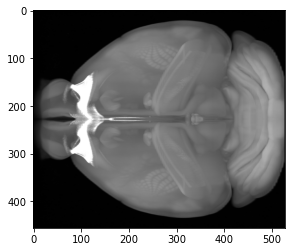

In [3]:
Y = 160
#array = template[:,Y,:]
array = template.max(axis=1)
print(array.shape,array.dtype)
plt.imshow(array)

In [4]:

for swc_dir in glob.glob('swctree/*'):
    print('\n',swc_dir)
  
    for swc_swcfile in glob.glob(f'{swc_dir}/scale*.swc'):
        print(swc_swcfile)
        swc = np.loadtxt(swc_swcfile)
        df_swc = pd.DataFrame(swc,columns=['n', 'type', 'x', 'y', 'z', 'r', 'parent'])
        xz = np.round(df_swc[['x','z']].values)
        xz = xz.astype(np.uint16)
        
        mi = xz.min(axis=0)
        ma = xz.max(axis=0)
        print(mi,ma)
        XZ = np.array(np.meshgrid(list(range(max(0,mi[0]),min(528,ma[0]))),
                                   list(range(max(0,mi[1]),min(456,ma[1]))),
                                 )).astype(np.uint16)  
        print(XZ.shape,)
        XZ = XZ.reshape(2,XZ.shape[1]*XZ.shape[2]).T
        print(XZ.shape,)
        
        dist = distance.cdist(XZ, xz, 'euclidean').min(axis=1).astype(np.uint16)
        print(dist.shape,)
        xz = XZ[dist<4]
        print(xz.shape,)
        
        if swc_dir.split('type')[-1][0]=='8':#red
            nxz = (xz[:,1],xz[:,0],np.zeros(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]
            nxz = (xz[:,1],xz[:,0],np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0
            nxz = (xz[:,1],xz[:,0],2*np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0
        if swc_dir.split('type')[-1][0]=='9':#purple
            nxz = (xz[:,1],xz[:,0],np.zeros(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]
            nxz = (xz[:,1],xz[:,0],np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0  
            nxz = (xz[:,1],xz[:,0],2*np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]
        if swc_dir.split('type')[-1][0]=='3':#blue
            nxz = (xz[:,1],xz[:,0],np.zeros(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0
            nxz = (xz[:,1],xz[:,0],np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0   
            nxz = (xz[:,1],xz[:,0],2*np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]
        if swc_dir.split('type')[-1][0]=='4':#green
            nxz = (xz[:,1],xz[:,0],np.zeros(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0
            nxz = (xz[:,1],xz[:,0],np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]
            nxz = (xz[:,1],xz[:,0],2*np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0 
        if swc_dir.split('type')[-1][0]=='6':#yellow
            nxz = (xz[:,1],xz[:,0],np.zeros(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]
            nxz = (xz[:,1],xz[:,0],np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]
            nxz = (xz[:,1],xz[:,0],2*np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0              
        if swc_dir.split('type')[-1][0]=='1':#cyan
            nxz = (xz[:,1],xz[:,0],np.zeros(xz.shape[0]).astype(np.uint16))
            array[nxz] = 0 
            nxz = (xz[:,1],xz[:,0],np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]
            nxz = (xz[:,1],xz[:,0],2*np.ones(xz.shape[0]).astype(np.uint16))
            array[nxz] = template[:,Y,:][nxz]


 ../fig1dptype/type1-cyan
../fig1dptype/type1-cyan/scale_18867_3525_x9958_y10743.semi_r.swc
[146  74] [526 311]
(2, 237, 380)
(90060, 2)
(90060,)
(6361, 2)
../fig1dptype/type1-cyan/scale_18869_3398_x6248_y7047.semi_r.swc
[131  64] [563 315]
(2, 251, 397)
(99647, 2)
(99647,)
(11678, 2)
../fig1dptype/type1-cyan/scale_18869_3751_x5868_y6832.semi_r.swc
[163  55] [568 318]
(2, 263, 365)
(95995, 2)
(95995,)
(9784, 2)

 ../fig1dptype/type3_PSV-blue
../fig1dptype/type3_PSV-blue/scale_18869_00020.semi_r.swc
[286 144] [415 284]
(2, 140, 129)
(18060, 2)
(18060,)
(1760, 2)
../fig1dptype/type3_PSV-blue/scale_18869_7986_x18907_y11037.swc
[292 137] [418 287]
(2, 150, 126)
(18900, 2)
(18900,)
(1843, 2)
../fig1dptype/type3_PSV-blue/scale_18869_7989_x9123_y9916.swc
[290 142] [406 289]
(2, 147, 116)
(17052, 2)
(17052,)
(1690, 2)

 ../fig1dptype/type4-green
../fig1dptype/type4-green/scale_17109_1701_x8048_y22277.swc
[79 86] [161 336]
(2, 250, 82)
(20500, 2)
(20500,)
(7260, 2)
../fig1dptype/type4-green/sc

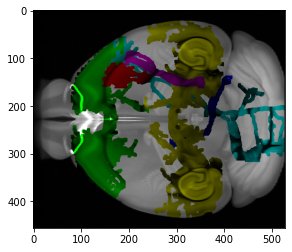

In [5]:
plt.imshow(array)
plt.savefig('signal.png',dpi=300)

In [6]:
# Y = 160
# for swc_dir in glob.glob('../fig1dptype/type*-*[a-z]'):
#     print('\n',swc_dir)
  
#     for swc_swcfile in glob.glob(f'{swc_dir}/scale*.swc'):
#         print(swc_swcfile)
#         swc = np.loadtxt(swc_swcfile)
#         df_swc = pd.DataFrame(swc,columns=['n', 'type', 'x', 'y', 'z', 'r', 'parent'])
#         xyz = np.round(df_swc[['x','y','z']].values)
#         xyz = xyz.astype(np.uint16)
        
#         mi = xyz.min(axis=0).astype(np.uint16)
#         ma = xyz.max(axis=0).astype(np.uint16)
#         xx = list(range(max(0,mi[0]),min(455,ma[0])))
#         yy = list(range(max(0,mi[1]),min(319,ma[1])))
#         zz = list(range(max(0,mi[2]),min(527,ma[2])))
#         XYZ = np.array(np.meshgrid(xx,yy,zz))
#         XYZT = XYZ.reshape(3,XYZ.shape[1]*XYZ.shape[2]*XYZ.shape[3]).T.astype(np.uint16)     
 
#         dist = distance.cdist(XYZT, xyz, 'euclidean').min(axis=1).astype(np.uint16)
#         xyz = XYZT[dist<10]
        
#         if swc_dir.split('type')[-1][0]=='1':#red
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],np.ones(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],2*np.ones(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0
#         if swc_dir.split('type')[-1][0]=='2':#purple
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],np.ones(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0
#         if swc_dir.split('type')[-1][0]=='3':#blue
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],np.zeros(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],np.ones(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0            
#         if swc_dir.split('type')[-1][0]=='4':#green
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],np.zeros(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],2*np.ones(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0   
#         if swc_dir.split('type')[-1][0]=='6':#yellow
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],2*np.ones(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0               
#         if swc_dir.split('type')[-1][0]=='8':#cyan
#             nxyz = (xyz[:,0],Y*np.ones(xyz.shape[0]).astype(np.uint16),xyz[:,2],np.zeros(xyz.shape[0]).astype(np.uint16))
#             template[nxyz] = 0   

In [7]:
# template = template.astype(np.uint8)
# plt.imshow(template[:,Y,:,:])
# plt.savefig('signal.png',dpi=300)